
The Salary Dataset contains **6704 rows** and **6 columns** containing the following data:

1. **Age**
2. **Gender**
3. **Education Level**
4. **Job Title**
5. **Years of Experience**
6. **Salary**

First we pre-process, clean and model the data to standarsise and structure it.


# Importing Libraries

In [11]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error 

In [ ]:
# Importing Data

df = pd.read_csv(r'../dataset/Salary_Data.csv')
# Dropping null values from database
df.dropna(inplace=True)
# Checking unique value counts of Job Titles in the database
# print(df['Job Title'].value_counts())

# Reducing Job titles by omitting titles with less than 25 counts

job_title_count = df['Job Title'].value_counts()
job_title_edited = job_title_count[job_title_count<=25]
job_title_edited.count()

# Omitting titles with less than 25 counts

df['Job Title'] = df['Job Title'].apply(lambda x: 'Others' if x in job_title_edited else x )
print(df['Job Title'].to_list())
# print(df.head())

#Checking unique value count of Education Level

df['Education Level'].value_counts()

# Combining repeating values of education level

df['Education Level'].replace(["Bachelor's Degree","Master's Degree","phD"],["Bachelor's","Master's","PhD"],inplace=True)
df['Education Level'].unique()


In [13]:
# Creating dummies for Job titles
dummies = pd.get_dummies(df['Job Title'],drop_first=True)
df = pd.concat([df,dummies],axis=1)

# Drop Job Title column
df.drop('Job Title',inplace=True,axis=1)
# Label encoding the categorical variable
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
# Mapping Education Level column
education_mapping = {"High School": 0, "Bachelor's": 1, "Master's": 2, "PhD": 3}
df['Education Level'] = df['Education Level'].map(education_mapping)
df.head()



,Age,Gender,Education Level,Years of Experience,Salary,Content Marketing Manager,Data Analyst,Data Scientist,Digital Marketing Manager,Director of Data Science,...,Senior HR Generalist,Senior Human Resources Manager,Senior Product Marketing Manager,Senior Project Engineer,Senior Research Scientist,Senior Software Engineer,Software Developer,Software Engineer,Software Engineer Manager,Web Developer
0,32.0,1,1,5.0,90000.0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,28.0,0,2,3.0,65000.0,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,45.0,1,3,15.0,150000.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,36.0,0,1,7.0,60000.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,52.0,1,2,20.0,200000.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Predicting Salary**

3 Models will be used to predict the salary

1. Linear Regression
2. Deision Tree
3. Random Forest

In [14]:
# detecting the outliers in salary column using IQR method
Q1 = df.Salary.quantile(0.25) # First Quartile
Q3 = df.Salary.quantile(0.75) # Third Quartile

# Caltulation Interquartile
IQR = Q3-Q1

# Deetecting outliers lying 1.5x of IQR above and below Q1 and Q3 resp
lower = Q1-1.5*IQR
upper = Q3+1.5*IQR

In [15]:
df[df.Salary>upper]

,Age,Gender,Education Level,Years of Experience,Salary,Content Marketing Manager,Data Analyst,Data Scientist,Digital Marketing Manager,Director of Data Science,...,Senior HR Generalist,Senior Human Resources Manager,Senior Product Marketing Manager,Senior Project Engineer,Senior Research Scientist,Senior Software Engineer,Software Developer,Software Engineer,Software Engineer Manager,Web Developer


**No outliers in Q3**

In [16]:
df[df.Salary<lower]

,Age,Gender,Education Level,Years of Experience,Salary,Content Marketing Manager,Data Analyst,Data Scientist,Digital Marketing Manager,Director of Data Science,...,Senior HR Generalist,Senior Human Resources Manager,Senior Product Marketing Manager,Senior Project Engineer,Senior Research Scientist,Senior Software Engineer,Software Developer,Software Engineer,Software Engineer Manager,Web Developer


**No outliers in Q1**

<h2>Preparing the data for ML analysis by converting categorical job titles into a numerical format<h2>

In [17]:
# Separating the dataset into features and target

# Dataset conntaining all features(X) from df
X = df.drop('Salary',axis=1)

# Series containing target(Y) variable to be predicted
Y= df['Salary']

In [18]:
# Splitting data into 25% training and 75% test sets

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=42)
x_train.shape

(5023, 53)

In [19]:
# Create a dictionary for defining models and tuning hyperparameters

model_params = {
    'Linear_Regression':{
        'model':LinearRegression(),
        'params':{
            
        }
    },
    'Decision_Tree':{
        'model':DecisionTreeRegressor(),
        'params':{
            'max_depth':[2,4,6,8,10],
            'random_state':[0,42],
            'min_samples_split':[1,5,10,20]
        }
    },
    'Random_Forest':{
        'model':RandomForestRegressor(),
        'params':{
            'n_estimators':[10,30,20,50,80]
        }
    }
}

In [20]:
# Hyper parameter tuning through grid search cv
score=[]

for model_name,m in model_params.items():
    clf = GridSearchCV(m['model'],m['params'],cv=5,scoring='neg_mean_squared_error')
    clf.fit(x_train,y_train)
    
    score.append({
        'Model':model_name,
        'Params':clf.best_params_,
        'MSE(-ve)':clf.best_score_
    })
pd.DataFrame(score)    

,Model,Params,MSE(-ve)
0,Linear_Regression,{},-4.642012e+08
1,Decision_Tree,"{'max_depth': 10, 'min_samples_split': 5, 'ran...",-1.533744e+08
2,Random_Forest,{'n_estimators': 80},-6.845278e+07


In [21]:
# Order of the best models 

s = pd.DataFrame(score)
sort = s.sort_values(by = 'MSE(-ve)',ascending=False)
sort

,Model,Params,MSE(-ve)
2,Random_Forest,{'n_estimators': 80},-6.845278e+07
1,Decision_Tree,"{'max_depth': 10, 'min_samples_split': 5, 'ran...",-1.533744e+08
0,Linear_Regression,{},-4.642012e+08


In [22]:
# Random Forest model

rfr = RandomForestRegressor(n_estimators=20)
rfr.fit(x_train,y_train)
print(x_train['Education Level'].value_counts())

Education Level
1    2271
2    1379
3    1033
0     340
Name: count, dtype: int64


In [23]:
rfr.score(x_test,y_test)
x_test.head()
y_test.head()
        
# y_test.head(1)

1883    150000.0
2630     75969.0
498     100000.0
5973     60000.0
4108     80000.0
Name: Salary, dtype: float64

In [24]:
y_pred_rfr = rfr.predict(x_test)

print("Mean Squared Error :",mean_squared_error(y_test,y_pred_rfr))
print("Mean Absolute Error :",mean_absolute_error(y_test,y_pred_rfr))
print("Root Mean Squared Error :",mean_squared_error(y_test,y_pred_rfr,squared=False))

Mean Squared Error : 79065911.1388814
Mean Absolute Error : 3446.98854721569
Root Mean Squared Error : 8891.901435513182


In [25]:
# Decision Tree model

dtr = DecisionTreeRegressor(max_depth=10,min_samples_split=2,random_state=0)
dtr.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [26]:
dtr.score(x_test,y_test)

0.9412718508060915

In [27]:
y_pred_dtr = dtr.predict(x_test)

print("Mean Squared Error :",mean_squared_error(y_test,y_pred_dtr))
print("Mean Absolute Error :",mean_absolute_error(y_test,y_pred_dtr))
print("Root Mean Squared Error :",mean_squared_error(y_test,y_pred_dtr,squared=False))

Mean Squared Error : 167450277.6499436
Mean Absolute Error : 7646.740239931774
Root Mean Squared Error : 12940.258020995701


In [28]:
# Linear regression model

lr = LinearRegression()
lr.fit(x_train,y_train)

LinearRegression()

In [29]:
lr.score(x_test,y_test)

0.8329414604682001

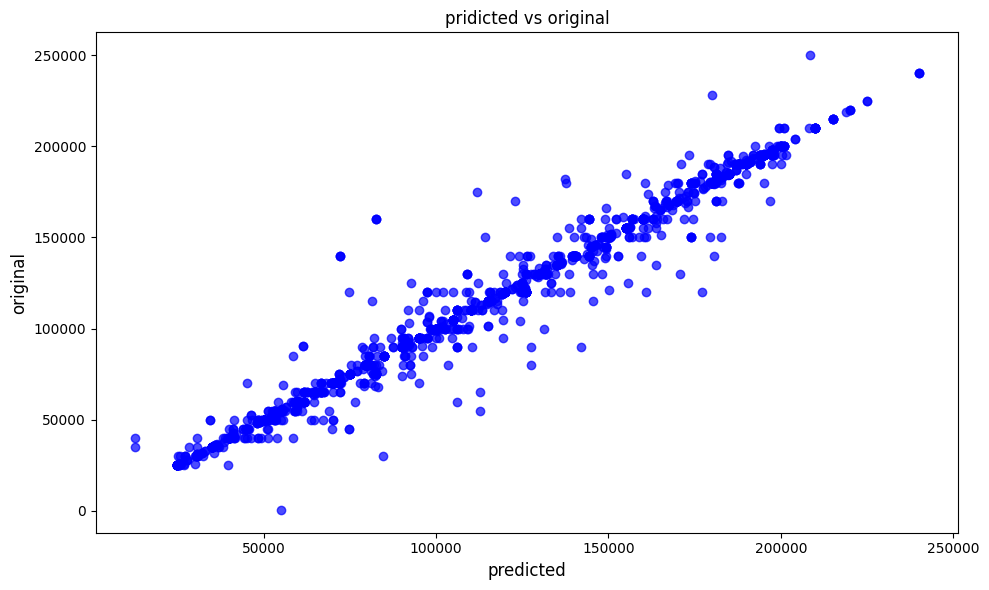

Mean Squared Error : 79065911.1388814
Mean Absolute Error : 3446.98854721569
Root Mean Squared Error : 8891.901435513182


In [30]:
y_pred_lr = rfr.predict(x_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_lr, y_test, color='blue', marker='o', alpha=0.7)
plt.xlabel('predicted', fontsize=12)
plt.ylabel('original', fontsize=12)
plt.title('pridicted vs original')
plt.tight_layout()
plt.show()


print("Mean Squared Error :",mean_squared_error(y_test,y_pred_lr))
print("Mean Absolute Error :",mean_absolute_error(y_test,y_pred_lr))
print("Root Mean Squared Error :",mean_squared_error(y_test,y_pred_lr,squared=False))

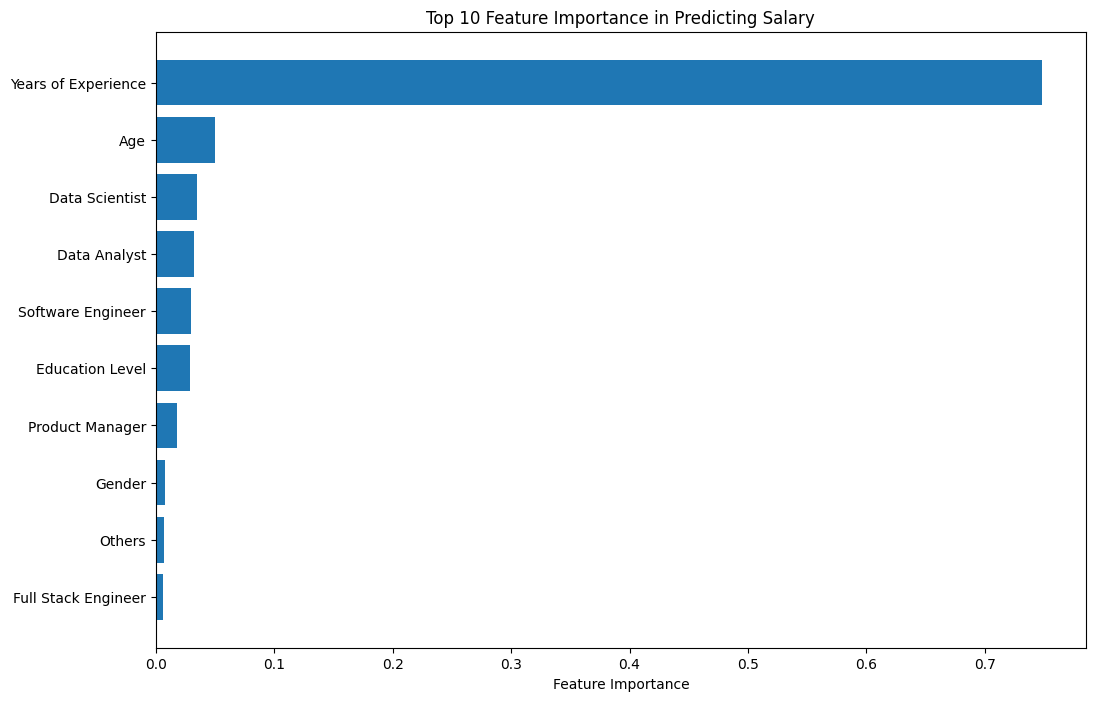

In [31]:
# Access the feature importances of Random Forest Regressor
feature_importances = rfr.feature_importances_

# Assuming you have a list of feature names that corresponds to the feature importances
feature_names = list(x_train.columns)

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = [feature_importances[i] for i in sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_feature_names[:10], sorted_feature_importances[:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance in Predicting Salary')
plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
plt.show()


**A bar chart depicting the importance of different features in predicting salary.**

<h2>Conclusion<h2>

**1. The Random Forest model achieved the highest R-squared score (0.971) and the lowest MSE, MAE, and RMSE values, indicating the best predictive performance among the three models.**

**2. The Decision Tree model performed well with an R-squared score of 0.941 but had higher errors compared to the Random Forest.**

**3. The Linear Regression model had the lowest R-squared score (0.833) and the highest errors, suggesting it may not capture the underlying patterns in the data as effectively as the ensemble models.**

In conclusion, the Random Forest model appears to be the most suitable for predicting salaries in this dataset, as it offers the highest predictive accuracy and the lowest error metrics. Further optimization and fine-tuning of the Random Forest model could potentially lead to even better results.

# Save the model
save the model in pkl file

In [32]:
#! Saving the model as a pickle file !!!
'''
import pickle

# save random forest model as a pickle file 
model_pkl_file = "salary predictor(rfr).pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(rfr, file)

# save linear regression model as a pickle file 
model_pkl_file = "salary predictor(lr).pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(lr, file)
    
# save Decsion tree model as a pickle file 
    
model_pkl_file = "salary predictor(dtr).pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(dtr, file)
model_pkl_file = "df.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(df, file)
'''

'\nimport pickle\n\n# save random forest model as a pickle file \nmodel_pkl_file = "salary predictor(rfr).pkl"  \n\nwith open(model_pkl_file, \'wb\') as file:  \n    pickle.dump(rfr, file)\n\n# save linear regression model as a pickle file \nmodel_pkl_file = "salary predictor(lr).pkl"  \n\nwith open(model_pkl_file, \'wb\') as file:  \n    pickle.dump(lr, file)\n    \n# save Decsion tree model as a pickle file \n    \nmodel_pkl_file = "salary predictor(dtr).pkl"  \n\nwith open(model_pkl_file, \'wb\') as file:  \n    pickle.dump(dtr, file)\nmodel_pkl_file = "df.pkl"  \n\nwith open(model_pkl_file, \'wb\') as file:  \n    pickle.dump(df, file)\n'